In [43]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature



datadir = "../data/"
figdir = "../figures/"

g = 9.81
f = 1e-4
r = 6371e3
omega = 7.29e-5
density_reference = 1028

In [44]:
hydrography = "woa"

density = xr.open_dataarray(datadir + f"density_{hydrography}_ease.nc")
density

<xarray.DataArray 'rho' (depth: 102, y: 264, x: 264)> Size: 57MB
[7108992 values with dtype=float64]
Coordinates:
  * depth    (depth) float32 408B 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
    lat      (y, x) float32 279kB ...
    lon      (y, x) float32 279kB ...
  * x        (x) int64 2kB 0 1 2 3 4 5 6 7 8 ... 256 257 258 259 260 261 262 263
  * y        (y) int64 2kB 0 1 2 3 4 5 6 7 8 ... 256 257 258 259 260 261 262 263
Attributes:
    standard_name:  sea_water_density
    units:          kg m^-3

In [45]:
buoyancy = -g*density/density_reference
buoyancy

<xarray.DataArray 'rho' (depth: 102, y: 264, x: 264)> Size: 57MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * depth    (depth) float32 408B 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
    lat      (y, x) float32 279kB ...
    lon      (y, x) float32 279kB ...
  * x        (x) int64 2kB 0 1 2 3 4 5 6 7 8 ... 256 257 258 259 260 261 262 263
  * y        (y) int64 2kB 0 1 2 3 4 5 6 7 8 ... 256 257 258 259 260 261 262 263

In [46]:
bgradx = buoyancy.where(~np.isnan(buoyancy)).differentiate("x")/25e3
bgradx.name = "dBdx"
bgrady = buoyancy.where(~np.isnan(buoyancy)).differentiate("y")/25e3
bgrady.name = "dBdy"

y, x = 80, 5
mindep = bgrady.sel(y=y, x=x, method="nearest").notnull()
print(mindep)
print(mindep.sum().values)
#print(bgradtheta.isel(lat=lat, lon=lon).isel(depth=mindep-1))
#bgrady.sel(y=y, x=x, method="nearest").plot()

<xarray.DataArray 'dBdy' (depth: 102)> Size: 102B
array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])
Coordinates:
  * depth    (depth) float32 408B 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
    lat      float32 4B 59.03
    lon      float32 4B -67.

In [47]:
dbdx = np.zeros((len(buoyancy.y), len(buoyancy.x)))
for i in range(len(buoyancy.y)):
    for j in range(len(buoyancy.x)):    
        seld = bgradx.isel(y=i, x=j).notnull().sum().values
        if seld >= 1e-4:
            dbdx[i, j] = bgradx.isel(y=i, x=j).isel(depth=slice(0, seld)).integrate("depth")

        else:
            dbdx[i, j] = np.nan
dbdx = xr.DataArray(dbdx,
                    dims=["y", "x"],
                    coords={"lat" : buoyancy.lat, "lon" : buoyancy.lon, "y" : buoyancy.y, "x" : buoyancy.x}
                    )
dbdx.name = "dBdx"
dbdx

<xarray.DataArray 'dBdx' (y: 264, x: 264)> Size: 558kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    lat      (y, x) float32 279kB ...
    lon      (y, x) float32 279kB ...
  * y        (y) int64 2kB 0 1 2 3 4 5 6 7 8 ... 256 257 258 259 260 261 262 263
  * x        (x) int64 2kB 0 1 2 3 4 5 6 7 8 ... 256 257 258 259 260 261 262 263

In [48]:
dbdy = np.zeros((len(buoyancy.y), len(buoyancy.x)))
for i in range(len(buoyancy.y)):
    for j in range(len(buoyancy.x)):    
        seld = bgrady.isel(y=i, x=j).notnull().sum().values
        if seld >= 1e-4:
            dbdy[i, j] = bgrady.isel(y=i, x=j).isel(depth=slice(0, seld)).integrate("depth")

        else:
            dbdy[i, j] = np.nan
dbdy = xr.DataArray(dbdy,
                    dims=["y", "x"],
                    coords={"lat" : buoyancy.lat, "lon" : buoyancy.lon, "y" : buoyancy.y, "x" : buoyancy.x}
                    )
dbdy.name = "dBdy"
dbdy

<xarray.DataArray 'dBdy' (y: 264, x: 264)> Size: 558kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    lat      (y, x) float32 279kB ...
    lon      (y, x) float32 279kB ...
  * y        (y) int64 2kB 0 1 2 3 4 5 6 7 8 ... 256 257 258 259 260 261 262 263
  * x        (x) int64 2kB 0 1 2 3 4 5 6 7 8 ... 256 257 258 259 260 261 262 263

In [49]:
f = 2*omega*np.sin(np.deg2rad(buoyancy.lat))

utherm = -dbdy/f
utherm.name = "ut"

vtherm = dbdx/f
vtherm.name = "vt"

thermal_wind = xr.merge([utherm, vtherm])
thermal_wind

<xarray.Dataset> Size: 2MB
Dimensions:  (y: 264, x: 264)
Coordinates:
    lat      (y, x) float32 279kB 47.33 47.5 47.67 47.84 ... 47.67 47.5 47.33
    lon      (y, x) float32 279kB -45.0 -44.78 -44.56 ... 135.4 135.2 135.0
  * y        (y) int64 2kB 0 1 2 3 4 5 6 7 8 ... 256 257 258 259 260 261 262 263
  * x        (x) int64 2kB 0 1 2 3 4 5 6 7 8 ... 256 257 258 259 260 261 262 263
Data variables:
    ut       (y, x) float64 558kB nan nan nan nan nan ... nan nan nan nan nan
    vt       (y, x) float64 558kB nan nan nan nan nan ... nan nan nan nan nan

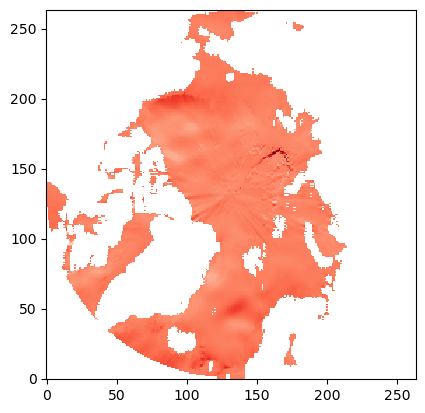

In [50]:
fig, ax = plt.subplots()
cm = ax.pcolormesh(thermal_wind.x, thermal_wind.y, thermal_wind.ut, cmap="Reds")
ax.set_aspect("equal")

In [51]:
thermal_wind.to_netcdf(datadir + "thermalwind_" + hydrography + "_ease.nc")